Обучить сиамскую сеть для верификации лиц на датасете LFW
1. Подключение библиотек

In [1]:
# general functions
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
# visualization
from PIL import Image
# identifying faces
%pip install mtcnn
from mtcnn.mtcnn import MTCNN
# visualizing bounding boxes
import matplotlib.patches as patches
# CNN
import keras
from sklearn.model_selection import train_test_split
# Moving files between directories
import shutil
from shutil import unpack_archive
from subprocess import check_output
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf
dataset_path = '/content/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/'

     |████████████████████████████████| 2.3MB 7.6MB/s 


In [2]:
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model


2. Скачивание данных

In [3]:
!pip install -q kaggle

In [4]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vladimirkaldin","key":"e8a8e0e22f98abec8d0b50ab61bc44f1"}'}

In [5]:
! mkdir ~/.kaggle

In [6]:
!cp kaggle.json ~/.kaggle/

In [7]:
!kaggle datasets download -d jessicali9530/lfw-dataset


100% 112M/112M [00:01<00:00, 68.0MB/s] 
100% 112M/112M [00:01<00:00, 106MB/s] 


In [8]:
!ls

kaggle.json  lfw-dataset.zip  sample_data


In [9]:
!mkdir lfw-dataset


In [10]:
!unzip lfw-dataset.zip -d lfw-dataset


Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0022.jpg  
  inflating: lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0023.jpg  
  inflating: lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0024.jpg  
  inflating: lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0025.jpg  
  inflating: lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0026.jpg  
  inflating: lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0027.jpg  
  inflating: lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0028.jpg  
  inflating: lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da

In [11]:
!ls lfw-dataset/lfw-deepfunneled/lfw-deepfunneled


Aaron_Eckhart			 Joshua_Harapko
Aaron_Guiel			 Joshua_Perper
Aaron_Patterson			 Joxel_Garcia
Aaron_Peirsol			 Joy_Bryant
Aaron_Pena			 Joy_Lee_Sadler
Aaron_Sorkin			 JP_Suarez
Aaron_Tippin			 JT_Snow
Abba_Eban			 Juan_Antonio_Samaranch
Abbas_Kiarostami		 Juan_Carlos
Abdel_Aziz_Al-Hakim		 Juan_Carlos_Ferrero
Abdel_Madi_Shabneh		 Juan_Carlos_Morales
Abdel_Nasser_Assidi		 Juan_Carlos_Ortega
Abdoulaye_Wade			 Juanes
Abdulaziz_Kamilov		 Juan_Fernandez
Abdullah			 Juan_Francisco_Palencia
Abdullah_Ahmad_Badawi		 Juan_Ignacio_Chela
Abdullah_al-Attiyah		 Juan_Jose_Lucas
Abdullah_Gul			 Juan_Manuel_Marquez
Abdullah_Nasseef		 Juan_Pablo_Montoya
Abdullatif_Sener		 Juan_Roman_Carrasco
Abdul_Majeed_Shobokshi		 Juan_Roman_Riquelme
Abdul_Rahman			 Juan_Sanchez
Abel_Aguilar			 Juan_Valencia_Osorio
Abel_Pacheco			 Judd_Davies
Abid_Hamid_Mahmud_Al-Tikriti	 Jude_Law
Abner_Martinez			 Judi_Dench
Abraham_Foxman			 Judi_Patton
Aby_Har-Even			 Judith_Nathan
Adam_Ant			 Judy_Dean
Adam_Freier			 Judy_Genshaft
A

In [12]:
!ls

kaggle.json  lfw-dataset  lfw-dataset.zip  sample_data


3. Чтение датафреймов

На основе https://www.kaggle.com/jake126/face-detection-using-cnn-with-the-lfw-dataset

In [13]:
# Data read-in and cleaning

lfw_allnames = pd.read_csv("/content/lfw-dataset/lfw_allnames.csv")
matchpairsDevTest = pd.read_csv("/content/lfw-dataset/matchpairsDevTest.csv")
matchpairsDevTrain = pd.read_csv("/content/lfw-dataset/matchpairsDevTrain.csv")
mismatchpairsDevTest = pd.read_csv("/content/lfw-dataset/mismatchpairsDevTest.csv")
mismatchpairsDevTrain = pd.read_csv("/content/lfw-dataset/mismatchpairsDevTrain.csv")
pairs = pd.read_csv("/content/lfw-dataset/pairs.csv")
# tidy pairs data: 
pairs = pairs.rename(columns ={'name': 'name1', 'Unnamed: 3': 'name2'})
matched_pairs = pairs[pairs["name2"].isnull()].drop("name2",axis=1)
mismatched_pairs = pairs[pairs["name2"].notnull()]
people = pd.read_csv("/content/lfw-dataset/people.csv")
# remove null values
people = people[people.name.notnull()]
peopleDevTest = pd.read_csv("/content/lfw-dataset/peopleDevTest.csv")
peopleDevTrain = pd.read_csv("/content/lfw-dataset/peopleDevTrain.csv")


4. Обзор данных

4.1. Разрешение изображений

In [14]:
# shape data frame so there is a row per image, matched to relevant jpg file
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images",1)

In [15]:
# verify resolution of all images is consistent
widths = []
heights = []
files = image_paths.image_path
for file in files:
    path = "/content/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/" + str(file)
    im = Image.open(path)
    widths.append(im.width)
    heights.append(im.height)

pd.DataFrame({'height':heights,'width':widths}).describe()

# all 250 x 250 resolution

,height,width
count,13233.0,13233.0
mean,250.0,250.0
std,0.0,0.0
min,250.0,250.0
25%,250.0,250.0
50%,250.0,250.0
75%,250.0,250.0
max,250.0,250.0



4.2. Дисбаланс классов

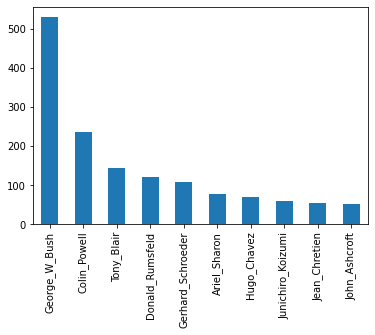

In [16]:
image_paths['name'].value_counts()[:10].plot(kind = "bar")


5. Формирование тренировочного и тестового датасетов

5.1. Формирование тренировочного датасета

5.1.1. Подготовка mismatchpairsDevTrain

In [17]:
# Добавляем колонку с z, которая для данного случая равна 0 для всех строк (картинки различны)
mismatchpairsDevTrain['z'] = 0

base = '/content/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'

mismatchpairsDevTrain.imagenum1 = mismatchpairsDevTrain.imagenum1.astype(str)
mismatchpairsDevTrain.imagenum2 = mismatchpairsDevTrain.imagenum2.astype(str)

mismatchpairsDevTrain['path_1'] = base + "/" + mismatchpairsDevTrain.name + \
"/" + mismatchpairsDevTrain.name + "_" + ('000' + mismatchpairsDevTrain.imagenum1).apply(lambda x: x[-4:]) + ".jpg"

mismatchpairsDevTrain['path_2'] = base + "/" + mismatchpairsDevTrain['name.1'] + \
"/" + mismatchpairsDevTrain['name.1'] + "_" + ('000' + mismatchpairsDevTrain.imagenum2).apply(lambda x: x[-4:]) + ".jpg"

mismatchpairsDevTrain.drop(columns = ['name', 'imagenum1', 'name.1', 'imagenum2'], inplace = True)

# Цикл отработал без ошибок, значит все адреса правильные
for i in range(mismatchpairsDevTrain.shape[0]):
  im = Image.open(mismatchpairsDevTrain.path_1[i])
  im = Image.open(mismatchpairsDevTrain.path_2[i])

5.1.2. Подготовка matchpairsDevTrain

In [18]:
# Добавляем колонку с z, которая для данного случая равна 1 для всех строк (картинки похожи)
matchpairsDevTrain['z'] = 1

base = '/content/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'

matchpairsDevTrain.imagenum1 = matchpairsDevTrain.imagenum1.astype(str)
matchpairsDevTrain.imagenum2 = matchpairsDevTrain.imagenum2.astype(str)

matchpairsDevTrain['path_1'] = base + "/" + matchpairsDevTrain.name + \
"/" + matchpairsDevTrain.name + "_" + ('000' + matchpairsDevTrain.imagenum1).apply(lambda x: x[-4:]) + ".jpg"

matchpairsDevTrain['path_2'] = base + "/" + matchpairsDevTrain.name + \
"/" + matchpairsDevTrain.name + "_" + ('000' + matchpairsDevTrain.imagenum2).apply(lambda x: x[-4:]) + ".jpg"

matchpairsDevTrain.drop(columns = ['name', 'imagenum1', 'imagenum2'], inplace = True)

# Цикл отработал без ошибок, значит все адреса правильные
for i in range(matchpairsDevTrain.shape[0]):
  im = Image.open(matchpairsDevTrain.path_1[i])
  im = Image.open(matchpairsDevTrain.path_2[i])

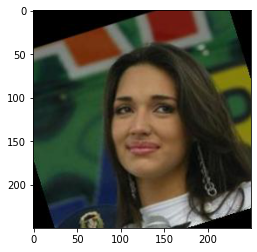

In [19]:
#Выведем некоторые изображения

im = Image.open(matchpairsDevTrain.path_1[50])
plt.imshow(im)

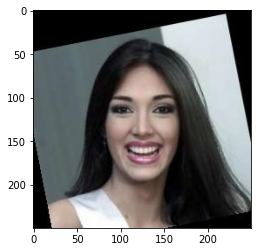

In [20]:
im = Image.open(matchpairsDevTrain.path_2[50])
plt.imshow(im)

5.1.3. Формируем итоговый тренировочный датафрейм

In [21]:
AllDevTrain = pd.concat([matchpairsDevTrain, mismatchpairsDevTrain])

from sklearn.utils import shuffle
AllDevTrain = shuffle(AllDevTrain)

AllDevTrain = AllDevTrain.reset_index().drop(columns = ['index'])

AllDevTrain.z.value_counts()

1    1100
0    1100
Name: z, dtype: int64

5.1.4. Формирование тренировочного датасета

In [22]:
AllDevTrain


,z,path_1,path_2
0,0,/content/lfw-dataset/lfw-deepfunneled/lfw-deep...,/content/lfw-dataset/lfw-deepfunneled/lfw-deep...
1,1,/content/lfw-dataset/lfw-deepfunneled/lfw-deep...,/content/lfw-dataset/lfw-deepfunneled/lfw-deep...
2,0,/content/lfw-dataset/lfw-deepfunneled/lfw-deep...,/content/lfw-dataset/lfw-deepfunneled/lfw-deep...
3,1,/content/lfw-dataset/lfw-deepfunneled/lfw-deep...,/content/lfw-dataset/lfw-deepfunneled/lfw-deep...
4,1,/content/lfw-dataset/lfw-deepfunneled/lfw-deep...,/content/lfw-dataset/lfw-deepfunneled/lfw-deep...
...,...,...,...
2195,1,/content/lfw-dataset/lfw-deepfunneled/lfw-deep...,/content/lfw-dataset/lfw-deepfunneled/lfw-deep...
2196,1,/content/lfw-dataset/lfw-deepfunneled/lfw-deep...,/content/lfw-dataset/lfw-deepfunneled/lfw-deep...
2197,0,/content/lfw-dataset/lfw-deepfunneled/lfw-deep...,/content/lfw-dataset/lfw-deepfunneled/lfw-deep...
2198,1,/content/lfw-dataset/lfw-deepfunneled/lfw-deep...,/content/lfw-dataset/lfw-deepfunneled/lfw-deep...


In [23]:
train_x = np.array([img_to_array(
                    load_img(img, target_size=(250, 250))
                    ) for img in AllDevTrain['path_1'].values.tolist()])

train_y = np.array([img_to_array(
                    load_img(img, target_size=(250, 250))
                    ) for img in AllDevTrain['path_2'].values.tolist()])

train_x = train_x.astype('float32')/255.0
train_y = train_y.astype('float32')/255.0

train_z = np.array(AllDevTrain['z'].values)
train_z = train_z.astype('float32')


5.2. Формирование тестового датасета

5.2.1 Подготовка mismatchpairsDevTest

In [24]:
# Добавляем колонку с z, которая для данного случая равна 0 для всех строк (картинки различны)
mismatchpairsDevTest['z'] = 0

base = '/content/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'

mismatchpairsDevTest.imagenum1 = mismatchpairsDevTest.imagenum1.astype(str)
mismatchpairsDevTest.imagenum2 = mismatchpairsDevTest.imagenum2.astype(str)

mismatchpairsDevTest['path_1'] = base + "/" + mismatchpairsDevTest.name + \
"/" + mismatchpairsDevTest.name + "_" + ('000' + mismatchpairsDevTest.imagenum1).apply(lambda x: x[-4:]) + ".jpg"

mismatchpairsDevTest['path_2'] = base + "/" + mismatchpairsDevTest['name.1'] + \
"/" + mismatchpairsDevTest['name.1'] + "_" + ('000' + mismatchpairsDevTest.imagenum2).apply(lambda x: x[-4:]) + ".jpg"

mismatchpairsDevTest.drop(columns = ['name', 'imagenum1', 'name.1', 'imagenum2'], inplace = True)

# Цикл отработал без ошибок, значит все адреса правильные
for i in range(mismatchpairsDevTest.shape[0]):
  im = Image.open(mismatchpairsDevTest.path_1[i])
  im = Image.open(mismatchpairsDevTest.path_2[i])

5.2.2. Подготовка matchpairsDevTest

In [25]:
# Добавляем колонку с z, которая для данного случая равна 1 для всех строк (картинки похожи)
matchpairsDevTest['z'] = 1

base = '/content/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'

matchpairsDevTest.imagenum1 = matchpairsDevTest.imagenum1.astype(str)
matchpairsDevTest.imagenum2 = matchpairsDevTest.imagenum2.astype(str)

matchpairsDevTest['path_1'] = base + "/" + matchpairsDevTest.name + \
"/" + matchpairsDevTest.name + "_" + ('000' + matchpairsDevTest.imagenum1).apply(lambda x: x[-4:]) + ".jpg"

matchpairsDevTest['path_2'] = base + "/" + matchpairsDevTest.name + \
"/" + matchpairsDevTest.name + "_" + ('000' + matchpairsDevTest.imagenum2).apply(lambda x: x[-4:]) + ".jpg"

matchpairsDevTest.drop(columns = ['name', 'imagenum1', 'imagenum2'], inplace = True)

# Цикл отработал без ошибок, значит все адреса правильные
for i in range(matchpairsDevTest.shape[0]):
  im = Image.open(matchpairsDevTest.path_1[i])
  im = Image.open(matchpairsDevTest.path_2[i])


5.2.3. Формируем итоговый тестовый датафрейм

In [26]:
AllDevTest = pd.concat([matchpairsDevTest, mismatchpairsDevTest])
from sklearn.utils import shuffle
AllDevTest = shuffle(AllDevTest)
AllDevTest = AllDevTest.reset_index().drop(columns = ['index'])
AllDevTest.z.value_counts()

1    500
0    500
Name: z, dtype: int64

5.2.4. Формирование тестового датасета


In [27]:
test_x = np.array([img_to_array(
                    load_img(img, target_size=(250, 250))
                    ) for img in AllDevTest['path_1'].values.tolist()])

test_y = np.array([img_to_array(
                    load_img(img, target_size=(250, 250))
                    ) for img in AllDevTest['path_2'].values.tolist()])

test_x = test_x.astype('float32')/255.0
test_y = test_y.astype('float32')/255.0

test_z = np.array(AllDevTest['z'].values)
test_z = test_z.astype('float32')

6. Визуализация датасета

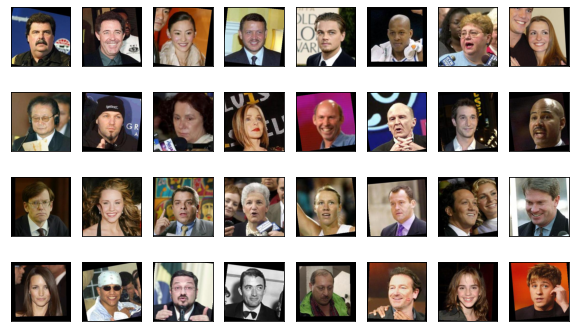

In [28]:
some_samples = test_x[:32, ...]

fig = plt.figure(figsize=(10, 6))
for j in range(some_samples.shape[0]):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j,:,:,:])
    plt.xticks([]), plt.yticks([])
plt.show()

7. Создание модели CNN

In [29]:
EMB_SIZE = 64

WEIGHT_DECAY = 0.001

wd = tf.keras.regularizers.l2(WEIGHT_DECAY)


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])


8. Функция ошибки

In [30]:
MARGIN = 10.0

def contastive_loss(embs1, embs2, z):
    
    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)


9. Подготовка пайплайна данных

In [31]:
BATCH_SIZE = 32
NUM_EPOCHS = 5

train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y, train_z))
#train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
#train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((test_x, test_y, test_z))
test_ds = test_ds.batch(BATCH_SIZE)

In [32]:
train_ds

<BatchDataset shapes: ((None, 250, 250, 3), (None, 250, 250, 3), (None,)), types: (tf.float32, tf.float32, tf.float32)>

10. Обучение модели

In [33]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [34]:
%%time
for epoch in range(NUM_EPOCHS):
  for iteration, (image1, image2, z) in enumerate(train_ds):
      
      # Forward
      with tf.GradientTape() as tape:
          embs1 = model(image1)
          embs2 = model(image2)
          loss_value = contastive_loss(embs1, embs2, z)
          
      # Backward
      grads = tape.gradient(loss_value, model.variables)
      optimizer.apply_gradients(zip(grads, model.variables))

      if iteration % 20 == 0:
          print('Epoch: {} [{}] Loss: {}'.format(epoch, iteration, loss_value.numpy()))

  # Проводим валидацию после каждой эпохи
  test_loss = 0
  for iteration, (image1, image2, z) in enumerate(test_ds):
    test_embs1 = model(image1)
    test_embs2 = model(image2)
    test_loss += contastive_loss(test_embs1, test_embs2, z).numpy()
  test_loss /= iteration
  print('Test loss:', test_loss)

Epoch: 0 [0] Loss: 52.37312698364258
Epoch: 0 [20] Loss: 24.042800903320312
Epoch: 0 [40] Loss: 25.458797454833984
Epoch: 0 [60] Loss: 28.01304817199707
Test loss: 31.647187263734878
Epoch: 1 [0] Loss: 34.57670211791992
Epoch: 1 [20] Loss: 19.79726219177246
Epoch: 1 [40] Loss: 22.850017547607422
Epoch: 1 [60] Loss: 29.864938735961914
Test loss: 25.738614359209613
Epoch: 2 [0] Loss: 25.11805534362793
Epoch: 2 [20] Loss: 20.628665924072266
Epoch: 2 [40] Loss: 23.440977096557617
Epoch: 2 [60] Loss: 27.305889129638672
Test loss: 26.504927850538685
Epoch: 3 [0] Loss: 23.12661361694336
Epoch: 3 [20] Loss: 21.21630096435547
Epoch: 3 [40] Loss: 23.14812469482422
Epoch: 3 [60] Loss: 22.43775177001953
Test loss: 23.841185046780495
Epoch: 4 [0] Loss: 20.009693145751953
Epoch: 4 [20] Loss: 20.34913444519043
Epoch: 4 [40] Loss: 18.81891441345215
Epoch: 4 [60] Loss: 23.420194625854492
Test loss: 23.327264908821352
CPU times: user 1min 53s, sys: 11.6 s, total: 2min 5s
Wall time: 2min 42s


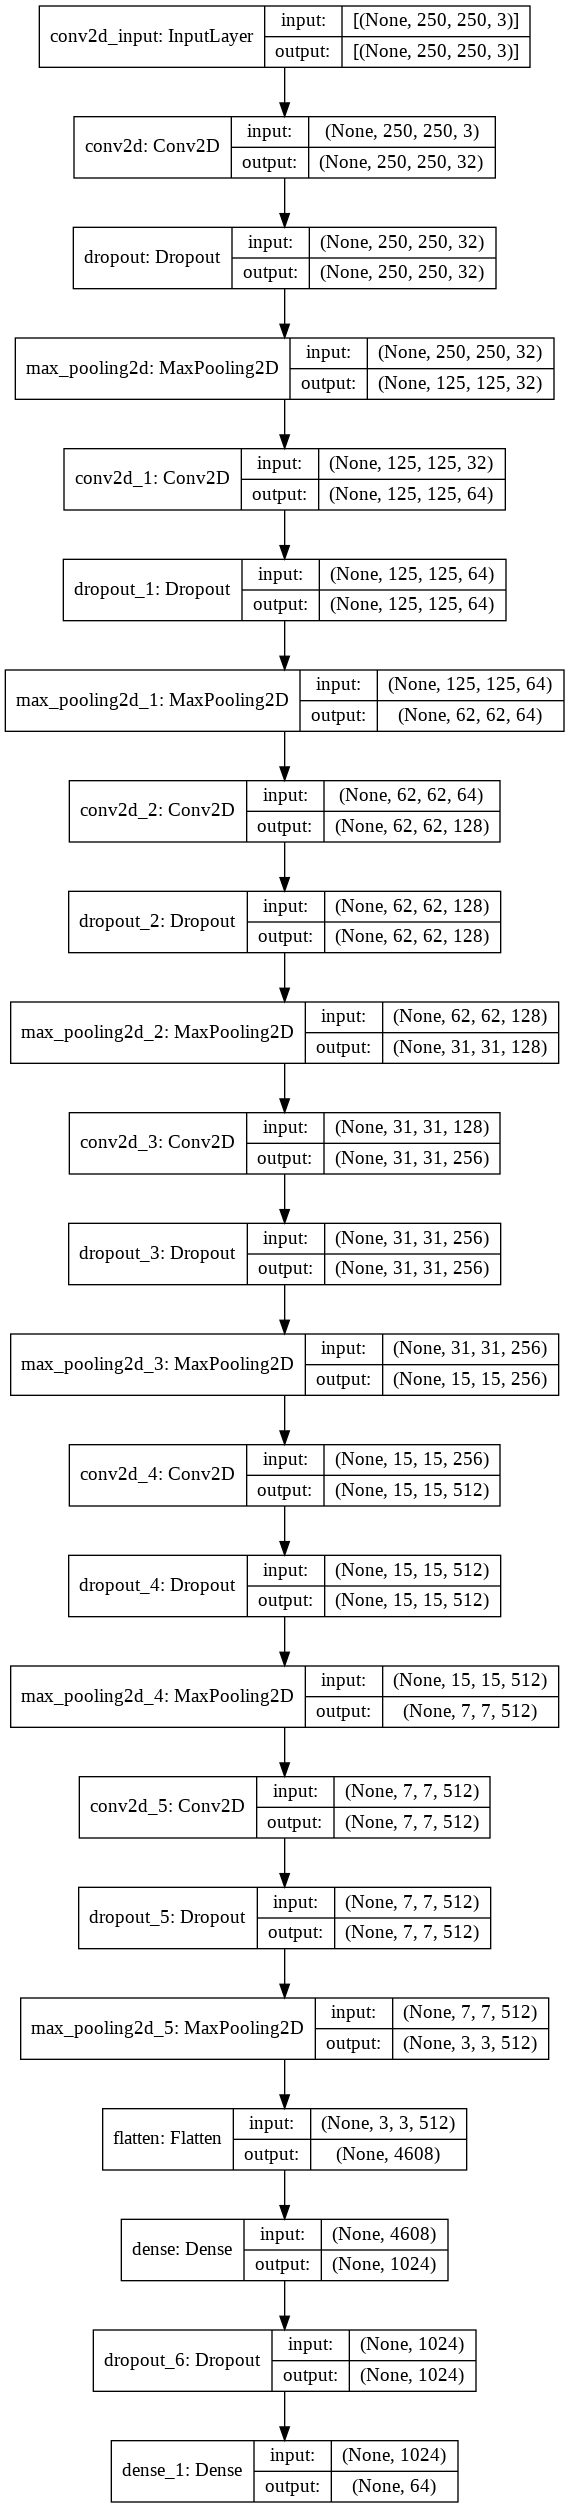

In [35]:
tf.keras.utils.plot_model(model, show_shapes=True)


11. Вычисление расстояний между эмбеддингами на новых данных


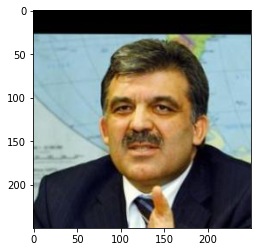

In [36]:
im1 = Image.open(matchpairsDevTest.path_1[0])
plt.imshow(im1)

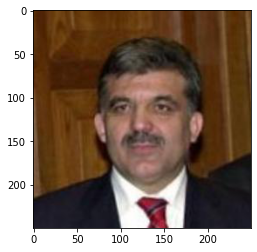

In [37]:
im2 = Image.open(matchpairsDevTest.path_2[0])
plt.imshow(im2)

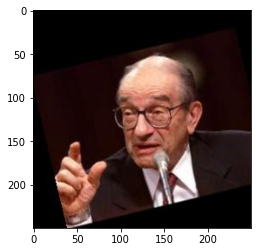

In [38]:
im3 = Image.open(matchpairsDevTest.path_2[5])
plt.imshow(im3)

In [39]:
new_embs = model(np.stack((im1, im2, im3), axis=0))


In [40]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

print('A1 <-> A2: ', diff(emb1, emb2))
print('A2 <-> B1: ', diff(emb2, emb3))
print('A1 <-> B1: ', diff(emb1, emb3))

A1 <-> A2:  758.0961350646763
A2 <-> B1:  840.0732482944568
A1 <-> B1:  800.6841605776899
